In [2]:
import pandas as pd
import numpy as np
import csv
import glob
import scipy
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
from datetime import datetime, timezone, timedelta
import voltaiq_studio as vs
from scipy.stats import norm
from scipy import integrate
import numpy.ma as ma

In [3]:
def add_features(i,data,n_cycles):
    reader = i.make_time_series_reader()
    reader.add_trace_keys('c_total_capacity','h_current', 'h_potential','h_test_time','h_step_index','h_charge_capacity', 'h_discharge_capacity', 'aux_vdf_temperature_celsius_0', 'aux_vdf_testtime_second_0','h_cycle','c_dv_dt', 'c_dq_dv')
    d = reader.read_pandas()
    data['Mean_temperature']=np.mean(d[d['h_cycle']==0]['aux_vdf_temperature_celsius_0'])
    data['Max_temperature']=np.max(d[d['h_cycle']==0]['aux_vdf_temperature_celsius_0'])
    data['Min_temperature']=np.min(d[d['h_cycle']==0]['aux_vdf_temperature_celsius_0'])
    for j in range(n_cycles):
        data['Mean_temperature'][j]=np.mean(d[d['h_cycle']==j]['aux_vdf_temperature_celsius_0'])
        data['Max_temperature'][j]=np.max(d[d['h_cycle']==j]['aux_vdf_temperature_celsius_0'])
        data['Min_temperature'][j]=np.min(d[d['h_cycle']==j]['aux_vdf_temperature_celsius_0'])
    return data

In [4]:
def remove_data(data,cycles='cyc_cycle'):
    data_new=[]
    max_cyc=[]
    max_cyc_900=[]
    n_cycles=4
    m=0
    x=len(data)
    for i in data:
        m+=1
        reader = i.make_cycle_stat_reader()
        cycle_stat_keys = list(i.get_cycle_stats().columns)
        d = reader.read_pandas()
        max_cycle=np.max(d[cycles])
        if(max_cycle>1000):
            Y1.append(6)
            d=d[0:5]
            #max_cyc_900.append(6)
            for k in range(len(d)):
                if 'delta_Q' in d.columns:
                    d['delta_Q'][k]=d['cyc_charge_capacity'][k]-d['cyc_charge_capacity'][k-1]
                else:
                    d['delta_Q']=0
            #print(m,len(data))
            data_new.append(add_features(i,d,n_cycles))
        else:
            if(max_cycle>900 and max_cycle<=1000):
                Y1.append(5)
            if(max_cycle>800 and max_cycle<=900):
                Y1.append(4)
            if(max_cycle>=700 and max_cycle<=800):
                Y1.append(3)
            if(max_cycle>=600 and max_cycle<=700):
                Y1.append(2)
            if(max_cycle<600):
                Y1.append(1)
            d=d[0:5]
            #max_cyc_900.append(0)
            data_new.append(add_features(i,d,n_cycles))
            for k in range(len(d)):
                if 'delta_Q' in d.columns:
                    d['delta_Q'][k]=d['cyc_charge_capacity'][k]-d['cyc_charge_capacity'][k-1]
                else:
                    d['delta_Q']=0
    return data_new,max_cyc,max_cyc_900,Y1

In [5]:
trs = vs.get_test_records() # Load All Test Records
filtered_trs = []
max_cyc=[]
max_cyc_900=[]
Y1=[]
# search for iphone test records
#tr_search = ['Attia_2020_CellID']
#tr_search = ['2017-05-12','2017-06-30','2018-04-12'] #,,'2017-05-12','2017-06-30','2019-01-29','2019-01-24','2018-04-12'
tr_search=['2018-04-12_batch8_CH10_VDF',
'2018-04-12_batch8_CH15_VDF',
'2018-04-12_batch8_CH34_VDF',
'2018-04-12_batch8_CH2_VDF',
'2018-04-12_batch8_CH11_VDF',
'2018-04-12_batch8_CH19_VDF',
'2018-04-12_batch8_CH35_VDF',
'2018-04-12_batch8_CH3_VDF',
'2018-04-12_batch8_CH43_VDF',
'2018-04-12_batch8_CH48_VDF',
'2018-04-12_batch8_CH8_VDF',
'2018-04-12_batch8_CH13_VDF',
'2018-04-12_batch8_CH18_VDF',
'2018-04-12_batch8_CH21_VDF',
'2018-04-12_batch8_CH23_VDF',
'2018-04-12_batch8_CH29_VDF',
'2018-04-12_batch8_CH37_VDF',
'2018-04-12_batch8_CH45_VDF',
'2018-04-12_batch8_CH5_VDF',
'2019-01-24_batch9_CH12_VDF',
'2018-04-12_batch8_CH14_VDF',
'2018-04-12_batch8_CH20_VDF',
'2018-04-12_batch8_CH22_VDF',
'2018-04-12_batch8_CH28_VDF',
'2018-04-12_batch8_CH36_VDF',
'2018-04-12_batch8_CH44_VDF',
'2018-04-12_batch8_CH4_VDF',
'2018-04-12_batch8_CH16_VDF',
'2018-04-12_batch8_CH30_VDF',
'2018-04-12_batch8_CH38_VDF',
'2017-05-12_6C-50per_3_6C_CH36_VDF',
'2018-04-12_batch8_CH39_VDF',
'2018-04-12_batch8_CH32_VDF',
'2017-05-12_6C-40per_3C_CH25_VDF',
'2017-05-12_6C-40per_3C_CH26_VDF',
'2017-05-12_7C-40per_3C_CH37_VDF',
'2017-05-12_7C-40per_3C_CH38_VDF',
'2017-05-12_5_4C-70per_3C_CH18_VDF',
'2017-05-12_6C-50per_3C_CH27_VDF',
'2017-05-12_6C-50per_3C_CH28_VDF',
'2019-01-24_batch9_CH7_VDF',
'2017-05-12_6C-30per_3_6C_CH32_VDF',
'2017-05-12_7C-30per_3_6C_CH39_VDF',
'2017-05-12_7C-30per_3_6C_CH40_VDF',
'2017-05-12_4_8C-80per_4_8C_CH10_VDF',
'2017-05-12_6C-40per_3_6C_CH33_VDF',
'2017-05-12_5_4C-60per_3C_CH15_VDF',
'2017-05-12_5_4C-60per_3C_CH16_VDF',
'2017-05-12_5_4C-60per_3_6C_CH23_VDF',
'2017-05-12_5_4C-60per_3_6C_CH24_VDF',
'2017-05-12_5_4C-70per_3C_CH17_VDF',
'2017-05-12_5_4C-50per_3C_CH14_VDF',
'2017-05-12_5_4C-80per_5_4C_CH11_VDF',
'2017-05-12_5_4C-80per_5_4C_CH12_VDF',
'2017-05-12_6C-50per_3_6C_CH35_VDF',
'2018-04-12_batch8_CH24_VDF',
'2017-05-12_6C-60per_3C_CH29_VDF',
'2017-05-12_6C-60per_3C_CH30_VDF',
'2018-04-12_batch8_CH40_VDF',
'2017-05-12_8C-15per_3_6C_CH43_VDF',
'2017-05-12_8C-15per_3_6C_CH44_VDF',
'2017-05-12_8C-25per_3_6C_CH45_VDF',
'2017-05-12_8C-25per_3_6C_CH46_VDF',
'2017-05-12_8C-35per_3_6C_CH47_VDF',
'2017-05-12_4_8C-80per_4_8C_CH9_VDF',
'2017-05-12_6C-40per_3_6C_CH34_VDF',
'2017-05-12_7C-40per_3_6C_CH42_VDF']
protocols=[1,
1,
1,
1,
2,
2,
2,
2,
2,
2,
2,
3,
3,
3,
3,
3,
3,
3,
3,
3,
4,
4,
4,
4,
4,
4,
4,
5,
5,
5,
6,
6,
7,
8,
8,
8,
8,
9,
9,
9,
9,
10,
10,
10,
11,
11,
12,
12,
13,
13,
14,
14,
15,
15,
16,
16,
17,
17,
18,
19,
19,
20,
20,
21,
22,
22,
22]
def filter_test_record_by_name(name):
    return [t for t in trs if name.lower() in t.name.lower()]
for i in tr_search:
    filtered_trs.extend(filter_test_record_by_name(i))
#print(len(new_filtered_trs))
new_filtered_trs,max_cyc,max_cyc_900,Y1=remove_data(filtered_trs)
print(len(new_filtered_trs),Y1)
print(len(tr_search),len(protocols))
#filtered_trs[5].remove(filtered_trs[5][14])
#print(len(filtered_trs[5]))

/tmp/ipykernel_106/1561241406.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['delta_Q'][k]=d['cyc_charge_capacity'][k]-d['cyc_charge_capacity'][k-1]
/tmp/ipykernel_106/1553475981.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mean_temperature'][j]=np.mean(d[d['h_cycle']==j]['aux_vdf_temperature_celsius_0'])
/tmp/ipykernel_106/1553475981.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Max_temperature'][j]=n

67 [6, 4, 4, 4, 6, 6, 5, 5, 6, 6, 5, 6, 4, 5, 4, 6, 4, 5, 3, 3, 6, 4, 4, 6, 6, 6, 3, 2, 3, 1, 4, 4, 6, 6, 4, 3, 2, 3, 4, 5, 5, 6, 3, 3, 2, 4, 4, 3, 4, 4, 2, 3, 1, 1, 3, 4, 3, 3, 3, 5, 6, 3, 2, 2, 4, 4, 2]
67 67


/tmp/ipykernel_106/1553475981.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Mean_temperature'][j]=np.mean(d[d['h_cycle']==j]['aux_vdf_temperature_celsius_0'])
/tmp/ipykernel_106/1553475981.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Max_temperature'][j]=np.max(d[d['h_cycle']==j]['aux_vdf_temperature_celsius_0'])
/tmp/ipykernel_106/1553475981.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Min_tempe

In [6]:
def select_y(data,cutoff,start,end):
    m=0
    while(end>m+start):
        if(data['cycle_number'][m+start]<cutoff):
            data.drop(m+start, axis=0, inplace=True)
        m+=1
    return data['cycle_number']

In [7]:
def normalize(df):
    # copy the data
    df_z_scaled = df.copy()
    # apply normalization techniques
    for column in df_z_scaled.columns:
        df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()
    # view normalized data
    return df_z_scaled

In [8]:
def compile_features_per_cell(data):
    df = pd.DataFrame()
    df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
    df['Mean_Q']=pd.Series(np.log(np.abs(np.mean(data['delta_Q']))))
    df['Mean_V']=pd.Series(np.log(np.abs(np.mean(data['cyc_mean_charge_potential']))))
    df['Variance_Q']=pd.Series(np.log(np.abs(np.sum((data['delta_Q']-np.mean(data['delta_Q']))**2)/(len(data)-1))))
    df['Skewness_Q']=pd.Series(np.log(np.abs((np.sum((data['delta_Q']-np.mean(data['delta_Q']))**3)/(len(data)))/((np.sum((data['delta_Q']-np.mean(data['delta_Q']))**2))**(3/2)))))
    df['Kurtosis_Q']=pd.Series(np.log(np.abs((np.sum((data['delta_Q']-np.mean(data['delta_Q']))**4)/(len(data)))/(((np.sum((data['delta_Q']-np.mean(data['delta_Q']))**2))/len(data))**(2)))))
    df['Variance_V']=pd.Series(np.log(np.abs(np.sum((data['cyc_mean_charge_potential']-np.mean(data['cyc_mean_charge_potential']))**2)/(len(data)-1))))
    df['Skewness_V']=pd.Series(np.log(np.abs((np.sum((data['cyc_mean_charge_potential']-np.mean(data['cyc_mean_charge_potential']))**3)/(len(data)))/((np.sum((data['cyc_mean_charge_potential']-np.mean(data['cyc_mean_charge_potential']))**2))**(3/2)))))
    df['Kurtosis_V']=pd.Series(np.log(np.abs((np.sum((data['cyc_mean_charge_potential']-np.mean(data['cyc_mean_charge_potential']))**4)/(len(data)))/(((np.sum((data['cyc_mean_charge_potential']-np.mean(data['cyc_mean_charge_potential']))**2))/len(data))**(2)))))
    df['Discharge_capacity']=pd.Series(data['cyc_discharge_capacity'][2])
    df['Diff_discharge_capacity']=pd.Series(np.max(data['cyc_discharge_capacity'])-data['cyc_discharge_capacity'][2])
    df['Avg_charge_time']=pd.Series(np.mean(data['cyc_total_charge_time'][2]+data['cyc_total_charge_time'][3]+data['cyc_total_charge_time'][4]))
    df['Max_temperature']=pd.Series(np.max(data['Max_temperature']))
    df['Min_temperature']=pd.Series(np.min(data['Min_temperature']))
    df['Temperature_integral']=integrate.cumtrapz(data['Mean_temperature'], data['cyc_total_cycle_time']+data['cyc_rest_time'], initial=0)[4]
    df['Internal_resistance_cycle2']=pd.Series(data['cyc_ir_charge'][2])
    df['Min_Internal_resistance']=pd.Series(np.min(data['cyc_ir_charge']))
    df['Diff_internal_resistance']=pd.Series(data['cyc_ir_charge'][4]-data['cyc_ir_charge'][2])
    df['Coulombic_efficiency']=pd.Series(data['cyc_coulombic_efficiency'][4])
    return df

In [9]:
X = pd.DataFrame()
Y = pd.DataFrame()
for i in range(len(new_filtered_trs)):
    if i==40:
        continue
    j=new_filtered_trs[i]
    row_start=0
    row_end=int(len(j))
    y=pd.DataFrame(protocols)
    x=j[:][row_start:row_end]
    col=['cycle_number','cycle_ord','cyc_cv_discharge_time', 'cyc_cycle','cyc_discharge_relaxation_dpt',
           'cyc_max_ocp', 'cyc_max_ocp_dpt','cyc_min_ocp', 'cyc_min_ocp_dpt','cyc_end_test_time', 'cyc_start_datapoint_time',
           'cyc_end_datapoint_time','cyc_min_discharge_power', 'cyc_net_capacity', 'cyc_net_energy','cyc_temp_comp_discharge_capacity',
            'cyc_temp_comp_total_discharge_time','cyc_charge_relaxation_potential','cyc_charge_relaxation_dpt',
            'cyc_cv_charge_time', 'cyc_discharge_relaxation_potential','cyc_const_voltage_charge_capacity','cyc_const_voltage_charge_capacity',
            'cyc_const_voltage_charge_energy','cyc_cv_charge_time','cyc_cv_discharge_time',
        'cyc_cv_charge_time','cyc_cv_discharge_time','cyc_charge_relaxation_dpt','cyc_charge_relaxation_potential','cyc_temp_comp_discharge_capacity',
        'cyc_temp_comp_total_discharge_time']
    x.drop(col, axis=1, inplace=True)
    x=x.dropna(axis=1)
    x=compile_features_per_cell(x)
    if X.empty:
        X=x
        Y=y
    else:
        X=pd.concat([X, x], axis=0, join='inner',ignore_index=True)
X.reset_index(drop=True)
X.replace([np.inf, -np.inf], 0, inplace=True)
X=normalize(X)
num_feats=8
headers=X.columns
del protocols[40]

/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero encountered in log
  df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero encountered in log
  df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero encountered in log
  df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero encountered in log
  df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero encountered in log
  df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero encountered in log
  df['Minimum_Q']=pd.Series(np.log(np.abs(np.min(data['delta_Q']))))
/tmp/ipykernel_106/2494085713.py:3: RuntimeWarning: divide by zero enc

# Feature selection using Support Vector Machine

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_106/1973070883.py:6: RuntimeWarning: divide by zero encountered in log
  plt.barh(range(len(names)), np.log(np.abs(imp)), align='center')


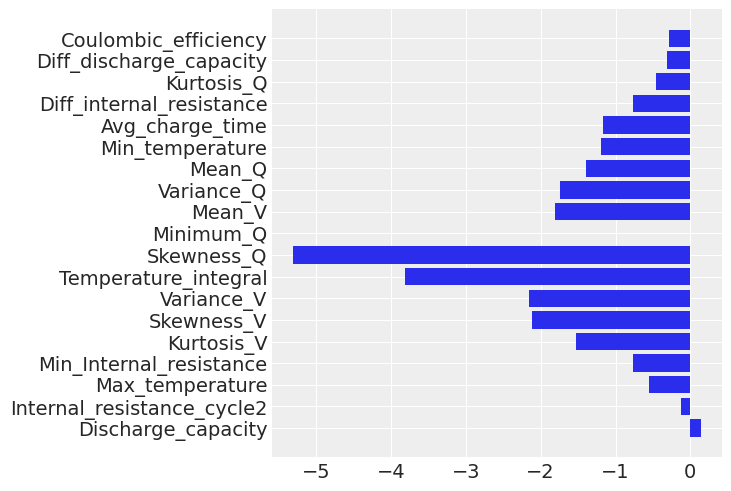

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6666666666666666

In [194]:
from matplotlib import pyplot as plt
from sklearn import svm
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), np.log(np.abs(imp)), align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    return names
features_names = headers
svm = svm.SVC(kernel='linear')
svm.fit(X.iloc[:66], Y.iloc[:66])
names=f_importances(svm.coef_[0], features_names)
svm.fit(X.iloc[:66], Y.iloc[:66]).score(X.iloc[:66], Y.iloc[:66])

In [204]:
maj_features_names = names[-7:]

# Battery lifetime classification using Support Vector Machine

In [203]:
from matplotlib import pyplot as plt
from sklearn import svm
print(len(protocols))
features_names = headers
svm = svm.SVC(kernel='linear')
svm.fit(X.iloc[:60][maj_features_names], protocols[:60])
print("Accuracy of lifetime classifcation:",svm.fit(X.iloc[:60][maj_features_names], protocols[:60]).score(X.iloc[:60][maj_features_names], protocols[:60]))

66
Accuracy of lifetime classifcation: 0.5666666666666667


# Installation of Bayesian libraries

In [12]:
!pip install arviz
!pip install pymc3

  Using cached arviz-0.12.1-py3-none-any.whl (1.6 MB)
  Using cached netCDF4-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.1 MB)
  Using cached xarray_einstats-0.3.0-py3-none-any.whl (34 kB)
  Using cached cftime-1.6.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached pymc3-3.11.5-py3-none-any.whl (872 kB)
  Using cached Theano_PyMC-1.1.2-py3-none-any.whl
  Using cached semver-2.13.0-py2.py3-none-any.whl (12 kB)
  Using cached scipy-1.7.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.8 MB)
  Using cached deprecat-2.1.1-py2.py3-none-any.whl (9.8 kB)
  Using cached numpy-1.22.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Using cached fastprogress-1.0.3-py3-none-any.whl (12 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.2
    Uninstalling numpy-1.22.2:
      Successfully uninstalled numpy-1.22.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.4

# Bayesian classification into protocols

In [13]:
# Import modules.
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import scipy.stats
import seaborn as sns

# Set seed for reproducibility.
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

# Set figure style.
az.style.use("arviz-darkgrid")
theta=[]

In [168]:
my_dict = {i:protocols.count(i) for i in protocols}         # number of cells in each protocols

In [15]:
def convert_to_probab(Y1,protocols):
    print(len(protocols))
    l=[0]*(np.max(protocols)+1)
    m=[0]*(np.max(protocols)+1)
    n=[0]*(np.max(protocols)+1)
    o=[0]*(np.max(protocols)+1)
    p=[0]*(np.max(protocols)+1)
    q=[0]*(np.max(protocols)+1)
    theta=[]
    for i in range(len(protocols)):
        if(Y1[i]==1):
            l[protocols[i]]+=1
        elif(Y1[i]==2):
            m[protocols[i]]+=1
        elif(Y1[i]==3):
            n[protocols[i]]+=1
        elif(Y1[i]==4):
            o[protocols[i]]+=1
        elif(Y1[i]==5):
            p[protocols[i]]+=1
        elif(Y1[i]==6):
            q[protocols[i]]+=1
        else:
            print("Protocol not found")
    for i in my_dict:
        s=0
        if l[i]==0:
            l[i]=0.000000000001
            s+=0.000000000001
        if m[i]==0:
            m[i]=0.000000000001
            s+=0.000000000001
        if n[i]==0:
            n[i]=0.000000000001
            s+=0.000000000001
        if o[i]==0:
            o[i]=0.000000000001
            s+=0.000000000001
        if p[i]==0:
            p[i]=0.000000000001
            s+=0.000000000001
        if q[i]==0:
            q[i]=0.000000000001
            s+=0.000000000001
        s=l[i]+m[i]+n[i]+o[i]+p[i]+q[i]
        sum_s=[l[i]/(s), m[i]/(s), n[i]/(s), o[i]/(s), p[i]/(s), q[i]/(s)]
        if(np.sum(sum_s)>1):
            for i in range(len(sum_s)):
                sum_s[i]-=(np.sum(sum_s)-1)/len(sum_s)
        theta.append(sum_s)
    return theta

In [16]:
theta=convert_to_probab(Y1,protocols)

66


In [166]:
true_p=[]
observed_counts=[]
for i in range(len(theta)):
    n=22                    # number of protocols
    total_count=66          # total number of cells
    true_p=sp.stats.dirichlet(theta[i]).rvs(size=n)
    for p_i in true_p:
        if(np.sum(p_i)>1):
            for i in range(len(p_i)):
                p_i[i]=round(p_i[i], 5)
    observed_counts.append(np.vstack([sp.stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p]))

In [18]:
# True parameter values
alpha, sigma = 1, 1
beta = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9]

# Size of dataset
size = 66

In [19]:
print(X.keys())

Index(['Minimum_Q', 'Mean_Q', 'Mean_V', 'Variance_Q', 'Skewness_Q',
       'Kurtosis_Q', 'Variance_V', 'Skewness_V', 'Kurtosis_V',
       'Discharge_capacity', 'Diff_discharge_capacity', 'Avg_charge_time',
       'Max_temperature', 'Min_temperature', 'Temperature_integral',
       'Internal_resistance_cycle2', 'Min_Internal_resistance',
       'Diff_internal_resistance', 'Coulombic_efficiency'],
      dtype='object')


In [80]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=19)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha+beta[0]*X['Minimum_Q']+beta[1]*X['Mean_Q']+beta[2]*X['Mean_V']+beta[3]*X['Variance_Q']+beta[4]*X['Skewness_Q']+beta[5]*X['Kurtosis_Q']+beta[6]*X['Variance_V']+beta[7]*X['Skewness_V']+beta[8]*X['Kurtosis_V']+beta[9]*X['Discharge_capacity']+beta[10]*X['Diff_discharge_capacity']+beta[11]*X['Avg_charge_time']+beta[12]*X['Max_temperature']+beta[13]*X['Min_temperature']+beta[14]*X['Temperature_integral']+beta[15]*X['Internal_resistance_cycle2']+beta[16]*X['Min_Internal_resistance']+beta[17]*X['Diff_internal_resistance']+beta[18]*X['Coulombic_efficiency']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [21]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'alpha': array(8.7156169),
 'beta': array([-2.83088699e-14, -1.23683718e-13, -8.23123652e-13, -7.03489588e-14,
        -1.45424994e-14, -7.25184879e-14,  3.23884117e-13,  2.90116883e-15,
        -4.89969089e-14,  4.11987279e-13, -2.39375331e-14,  2.92288577e-13,
         4.60805542e-14, -2.97560042e-14, -6.56401783e-13,  3.64415304e-15,
        -3.20270766e-14,  4.05717131e-14,  3.26528858e-12]),
 'sigma_log__': array(1.85268423),
 'sigma': array(6.37691367)}

In [22]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

In [150]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(66, step=step, return_inferencedata=False)

/opt/conda/lib/python3.9/site-packages/pymc3/sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


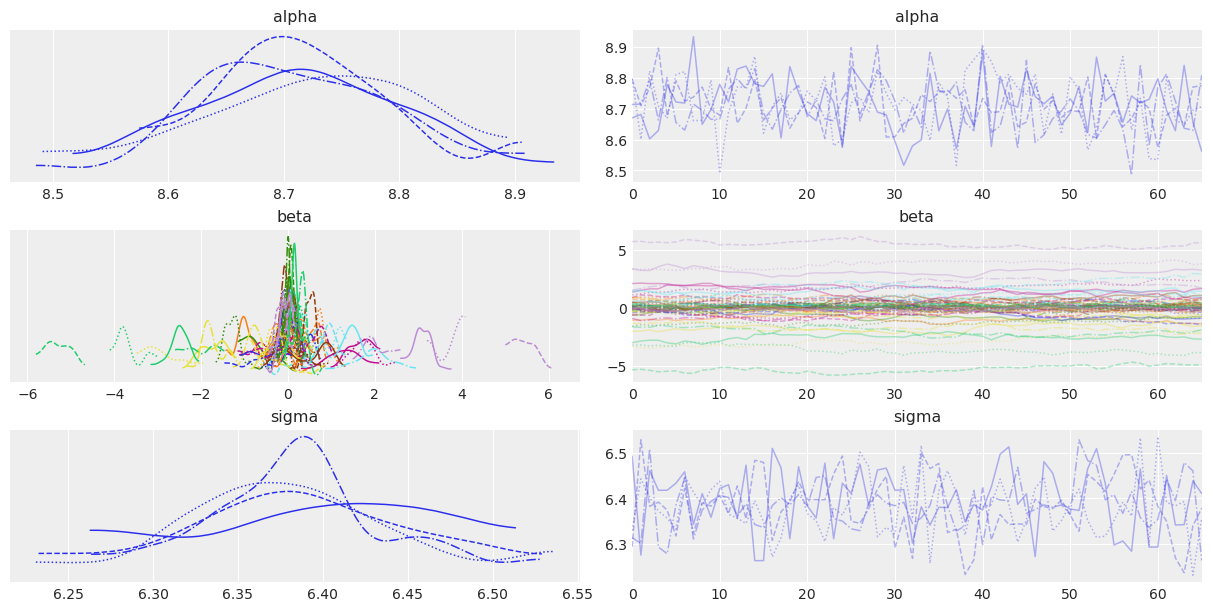

In [151]:
with basic_model:
    az.plot_trace(trace);

In [170]:
# collect posterior and log_likelihood
with basic_model:
    idata = az.from_pymc3(trace)
print(idata)

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data


In [153]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.71,0.08,8.57,8.87,0.01,0.00,269.13,232.94,1.03
beta[0],-0.01,0.16,-0.29,0.30,0.03,0.02,25.93,83.64,1.11
beta[1],0.23,0.75,-1.20,1.09,0.35,0.26,6.18,15.93,1.95
beta[2],-0.50,0.59,-1.47,0.35,0.26,0.20,5.54,25.18,2.23
beta[3],0.58,1.17,-1.08,2.08,0.55,0.41,5.32,21.24,2.44
beta[4],-0.01,0.19,-0.32,0.34,0.05,0.03,16.95,109.71,1.18
beta[5],0.29,0.33,-0.22,0.90,0.13,0.10,7.00,38.28,1.67
beta[6],-1.27,1.19,-3.35,0.49,0.56,0.42,4.88,11.31,3.23
beta[7],-3.37,1.29,-5.57,-1.57,0.60,0.46,4.85,11.91,3.32
beta[8],3.58,1.27,1.68,5.74,0.60,0.45,4.78,15.52,3.57


In [178]:
# Predict output
y_pred_g = pm.sample_posterior_predictive(trace, 66, basic_model)
print("Shape of the sampled variable y and data ",np.shape(y_pred_g['Y_obs']), len(protocols))

Shape of the sampled variable y and data  (66, 67, 66) 66


# Plot of results

/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


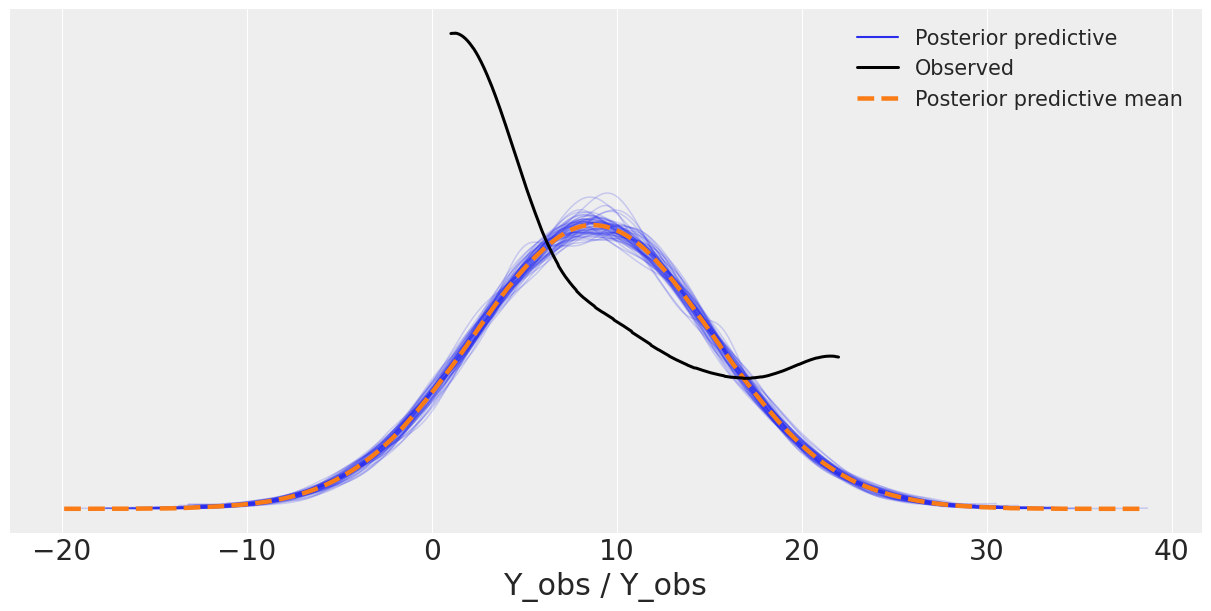

In [164]:
data_ppc = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
ax.legend(fontsize=15);

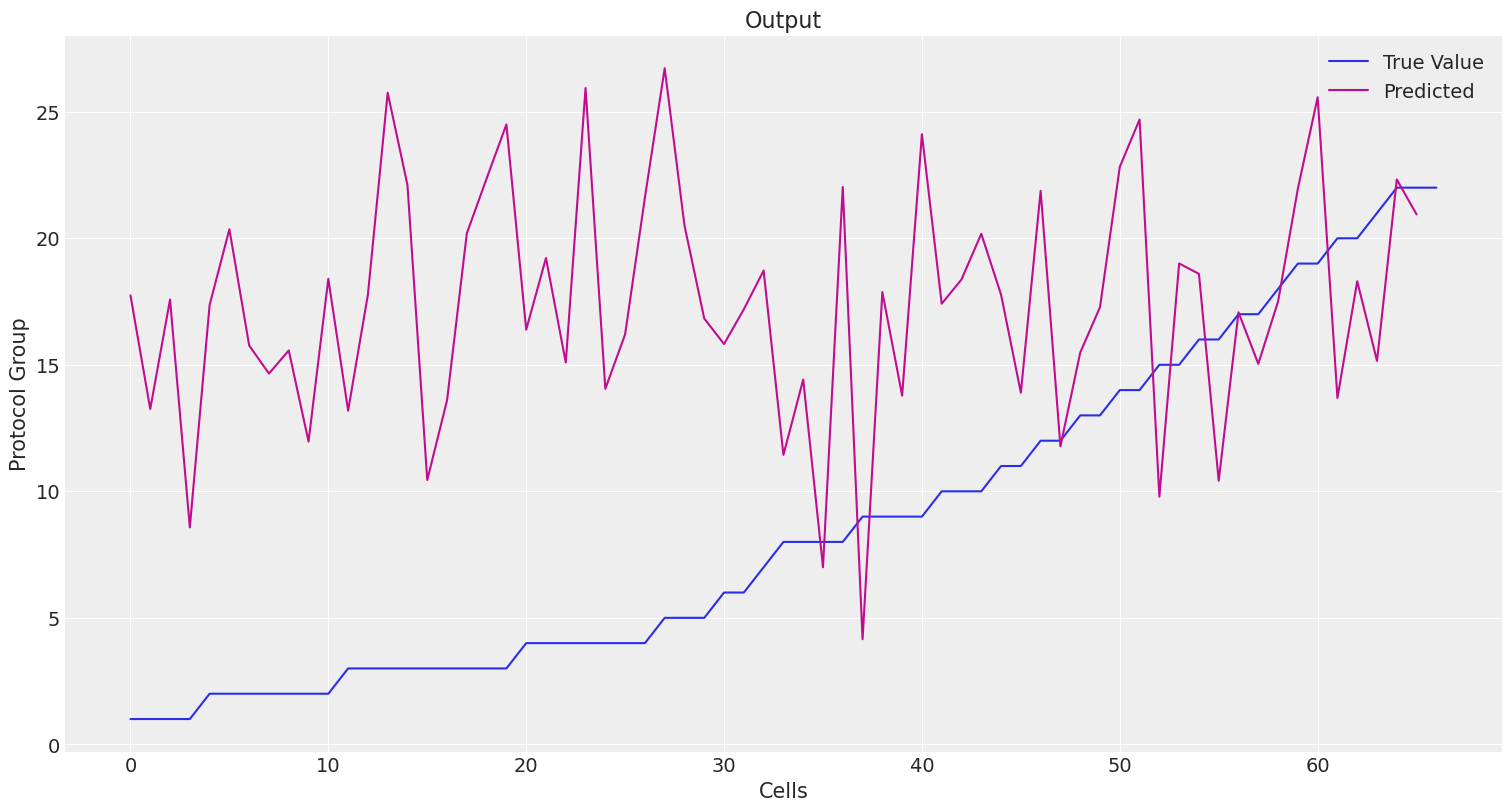

In [176]:
fig, ax = plt.subplots(figsize=(15, 8))
Y.plot(ax=ax)
ax.plot(Y.index[:66],np.max(y_pred_g['Y_obs'][0],axis=0)+np.min(y_pred_g['Y_obs'][0],axis=0), 'C3')
#ax.plot(Y.index[:66],idata['observed_data']['Y_obs'][:66], 'C3')
ax.set(title="Output", xlabel="Cells", ylabel="Protocol Group")
ax.legend(["True Value", "Predicted"], loc="upper right");